In [51]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms.v2 as v2
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

torch.Size([1, 32, 32])
Image([[[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]], )


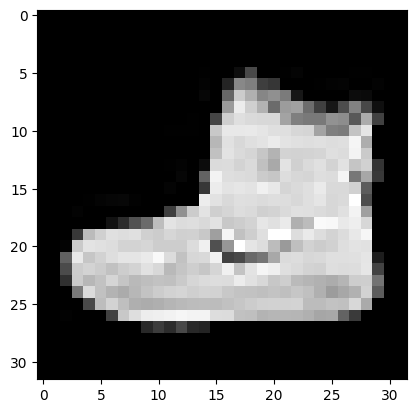

In [2]:
transform = v2.Compose(
    [
        v2.Pad(2),
        v2.ToImageTensor(),
        v2.ConvertImageDtype(),
    ]
)

train_dataset = torchvision.datasets.FashionMNIST(
    root="./dataset", train=True, download=True, transform=transform
)
test_dataset = torchvision.datasets.FashionMNIST(
    root="./dataset", train=False, download=True, transform=transform
)

print(train_dataset[0][0].shape)
print(train_dataset[0][0])
plt.imshow(train_dataset[0][0].squeeze(), cmap="grey")

In [16]:
class Sampling(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
    
    def forward(self, z_mean, z_log_var):
        batch = z_mean.shape[0]
        dim = z_mean.shape[1]
        epsilion = torch.randn([batch, dim])
        epsilion = epsilion.to(z_mean.device)
        return z_mean + torch.exp(0.5 * z_log_var) * epsilion

class Encoder(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.conv1 = nn.Conv2d(
            in_channels=1, out_channels=32, kernel_size=3, stride=2, padding=1
        )  # 16 x 16
        self.conv2 = nn.Conv2d(
            in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1
        )  # 8 x 8
        self.conv3 = nn.Conv2d(
            
            in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1
        )  # 4 x 4
        self.activation = nn.ReLU()
        self.flatten = nn.Flatten()
        self.dense_z_mean = nn.Linear(in_features=128 * 4 * 4, out_features=2)
        self.dense_z_log_var = nn.Linear(in_features=128 * 4 * 4, out_features=2)
        self.sampling = Sampling()

    def forward(self, x):
        out = self.conv1(x)
        out = self.activation(out)
        out = self.conv2(out)
        out = self.activation(out)
        out = self.conv3(out)
        out = self.activation(out)
        out = self.flatten(out)
        
        z_mean = self.dense_z_mean(out)
        z_log_var = self.dense_z_log_var(out)
        z = self.sampling(z_mean, z_log_var)

        return z_mean, z_log_var, z

encoder = Encoder()
sample = train_dataset[0][0].unsqueeze(0)
print(sample.shape)
z_mean, z_log_var, z = encoder(sample)
print('z_mean:', z_mean)
print('z_log_var:', z_log_var)
print('z:', z)


torch.Size([1, 1, 32, 32])
z_mean: tensor([[ 0.0215, -0.0367]], grad_fn=<AddmmBackward0>)
z_log_var: tensor([[-0.0136,  0.0168]], grad_fn=<AddmmBackward0>)
z: tensor([[ 0.9249, -1.0960]], grad_fn=<AddBackward0>)


In [9]:
class Decoder(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.dense = nn.Linear(in_features=2, out_features=128 * 4 * 4)
        self.conv_tr1 = nn.ConvTranspose2d(
            in_channels=128,
            out_channels=128,
            kernel_size=3,
            stride=2,
            padding=1,
            output_padding=1,
        )
        self.conv_tr2 = nn.ConvTranspose2d(
            in_channels=128,
            out_channels=64,
            kernel_size=3,
            stride=2,
            padding=1,
            output_padding=1,
        )
        self.conv_tr3 = nn.ConvTranspose2d(
            in_channels=64,
            out_channels=32,
            kernel_size=3,
            stride=2,
            padding=1,
            output_padding=1,
        )
        self.conv = nn.Conv2d(
            in_channels=32, out_channels=1, kernel_size=3, stride=1, padding=1
        )
        self.activation = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.dense(x)
        out = out.reshape([-1, 128, 4, 4])
        out = self.conv_tr1(out)
        out = self.activation(out)
        out = self.conv_tr2(out)
        out = self.activation(out)
        out = self.conv_tr3(out)
        out = self.activation(out)
        out = self.conv(out)
        out = self.sigmoid(out)
        return out


decoder = Decoder()
sample = torch.randn([4, 2])
pred = decoder(sample)
print(pred.shape)

torch.Size([4, 1, 32, 32])


In [10]:
class AutoEncoder(nn.Module):
    def __init__(self, encoder, decoder, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        z_mean, z_log_var, z = self.encoder(x)
        out = self.decoder(z)
        return out, z_mean, z_log_var, z

In [41]:
def train(model, train_dl, n_epoch, lr, device):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # reduction이 mean 인 경우, MSE, KL 모두 평균에 의해 이미지가 중간화 되는 문제 발생.
    criterion = nn.MSELoss(reduction='sum')

    for epoch in range(n_epoch):
        encoder.train()
        decoder.train()
        pbar = tqdm(train_dl)
        pbar.set_description(f"epoch[{epoch}]")
        loss_sum = 0
        total_cnt = 0
        for _, (x, _) in enumerate(pbar):
            optimizer.zero_grad()
            x = x.to(device)
            pred, z_mean, z_log_var, z = model(x)
            x_compare = x.reshape(x.shape[0], -1)
            pred_compare = pred.reshape(pred.shape[0], -1)

            recon_loss = criterion(pred_compare, x_compare)
            kl_loss = -0.5 * torch.sum(1 + z_log_var - z_mean.pow(2) - z_log_var.exp())
            
            loss = recon_loss + kl_loss
            loss_sum += loss.item()
            total_cnt += x.shape[0]
            pbar.set_postfix_str(f"loss:{loss.item()}")
            loss.backward()
            optimizer.step()
        print(f"epoch[{epoch}], loss mean : {loss_sum/total_cnt}")

In [42]:
encoder = Encoder()
decoder = Decoder()
model = AutoEncoder(encoder, decoder)
device = "cuda" if torch.cuda.is_available() else "cpu"
train_dl = DataLoader(train_dataset, batch_size=128, shuffle=True)
train(model, train_dl, 20, 5e-4, device)

epoch[0]: 100%|██████████| 469/469 [00:07<00:00, 62.47it/s, loss:3091.6044921875]  


epoch[0], loss mean : 49.614348270670575


epoch[1]: 100%|██████████| 469/469 [00:07<00:00, 61.95it/s, loss:3062.179443359375]


epoch[1], loss mean : 31.22408319905599


epoch[2]: 100%|██████████| 469/469 [00:07<00:00, 63.22it/s, loss:3075.651123046875]


epoch[2], loss mean : 30.171518286132812


epoch[3]: 100%|██████████| 469/469 [00:07<00:00, 62.43it/s, loss:2489.18896484375] 


epoch[3], loss mean : 29.64257072347005


epoch[4]: 100%|██████████| 469/469 [00:07<00:00, 63.87it/s, loss:2735.583740234375]


epoch[4], loss mean : 29.276565087890624


epoch[5]: 100%|██████████| 469/469 [00:07<00:00, 63.79it/s, loss:3130.23291015625] 


epoch[5], loss mean : 29.007461018880207


epoch[6]: 100%|██████████| 469/469 [00:07<00:00, 63.19it/s, loss:3089.672119140625]


epoch[6], loss mean : 28.814582600911457


epoch[7]: 100%|██████████| 469/469 [00:07<00:00, 63.52it/s, loss:2704.38525390625] 


epoch[7], loss mean : 28.651435192871094


epoch[8]: 100%|██████████| 469/469 [00:07<00:00, 63.44it/s, loss:2648.51953125]    


epoch[8], loss mean : 28.506136083984376


epoch[9]: 100%|██████████| 469/469 [00:07<00:00, 62.74it/s, loss:2546.462890625]   


epoch[9], loss mean : 28.36457852783203


epoch[10]: 100%|██████████| 469/469 [00:07<00:00, 63.97it/s, loss:2759.937255859375]


epoch[10], loss mean : 28.267638330078125


epoch[11]: 100%|██████████| 469/469 [00:07<00:00, 63.97it/s, loss:2750.5048828125]  


epoch[11], loss mean : 28.113117834472657


epoch[12]: 100%|██████████| 469/469 [00:07<00:00, 63.06it/s, loss:2574.095703125]   


epoch[12], loss mean : 28.013163635253907


epoch[13]: 100%|██████████| 469/469 [00:07<00:00, 63.45it/s, loss:2784.172119140625]


epoch[13], loss mean : 27.926588814290366


epoch[14]: 100%|██████████| 469/469 [00:07<00:00, 62.97it/s, loss:2715.839111328125]


epoch[14], loss mean : 27.854865991210936


epoch[15]: 100%|██████████| 469/469 [00:07<00:00, 63.99it/s, loss:2804.49462890625] 


epoch[15], loss mean : 27.768006486002605


epoch[16]: 100%|██████████| 469/469 [00:07<00:00, 63.35it/s, loss:2966.7685546875]  


epoch[16], loss mean : 27.69256541748047


epoch[17]: 100%|██████████| 469/469 [00:07<00:00, 63.75it/s, loss:2599.802490234375]


epoch[17], loss mean : 27.64237402750651


epoch[18]: 100%|██████████| 469/469 [00:07<00:00, 63.28it/s, loss:2729.25830078125] 


epoch[18], loss mean : 27.586149287923178


epoch[19]: 100%|██████████| 469/469 [00:07<00:00, 63.66it/s, loss:2593.365478515625]

epoch[19], loss mean : 27.520876200358074


In [43]:
test_dl = DataLoader(test_dataset, batch_size=128, shuffle=False)
x, test_y = next(iter(test_dl))
x = x.to(device)
out, z_mean, z_log_var, z = model(x)
z = z.detach().cpu().numpy()

torch.Size([128, 1, 32, 32])
torch.Size([128, 1, 32, 32])


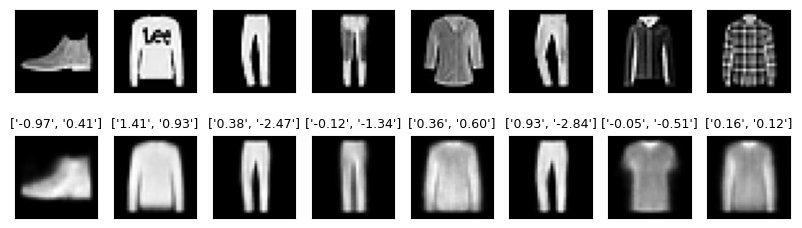

In [44]:
img = x[0].detach().cpu().squeeze().numpy()

fig, axs = plt.subplots(nrows=2, ncols=8, figsize=(10,3))
print(x.shape)
print(out.shape)
for i in range(8):
    x_img = x[i].detach().cpu().squeeze().numpy()
    pred_img = out[i].detach().cpu().squeeze().numpy()
    axs[0,i].set_xticks([])
    axs[0,i].set_yticks([])
    axs[1,i].set_xticks([])
    axs[1,i].set_yticks([])

    axs[0, i].imshow(x_img, cmap="grey")
    axs[1, i].imshow(pred_img, cmap="grey")

    latent_value = [f"{x:.2f}" for x in z[i]]
    axs[1, i].set_title(latent_value, fontsize=9)



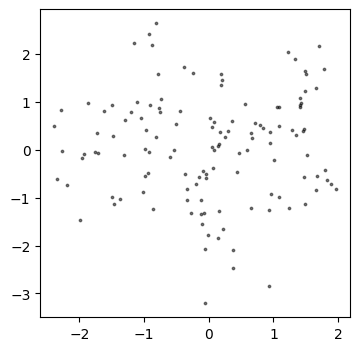

In [45]:
plt.figure(figsize=(4,4))
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=3)
plt.show()

In [58]:
y_total = []
z_total = []
z_mean_total = []
for step, (x, y) in enumerate(test_dl):
    x = x.to(device)
    z_mean, z_log_var, z = model.encoder(x)
    z = z.detach().cpu().numpy()
    z_total.extend(z)
    y_total.extend(y.numpy())
    z_mean_total.extend(z_mean.detach().cpu().numpy())

y_total = np.array(y_total)
z_total = np.array(z_total)
z_mean_total = np.array(z_mean_total)

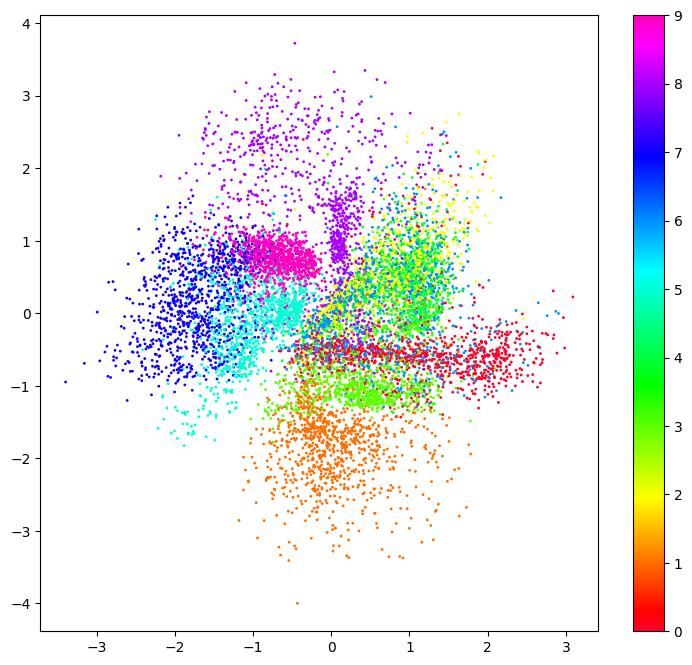

In [59]:
plt.figure(figsize=(9,8))
scatter = plt.scatter(z_total[:, 0], z_total[:, 1], c=y_total, s=1, cmap='gist_rainbow')
plt.colorbar(scatter)
plt.show()

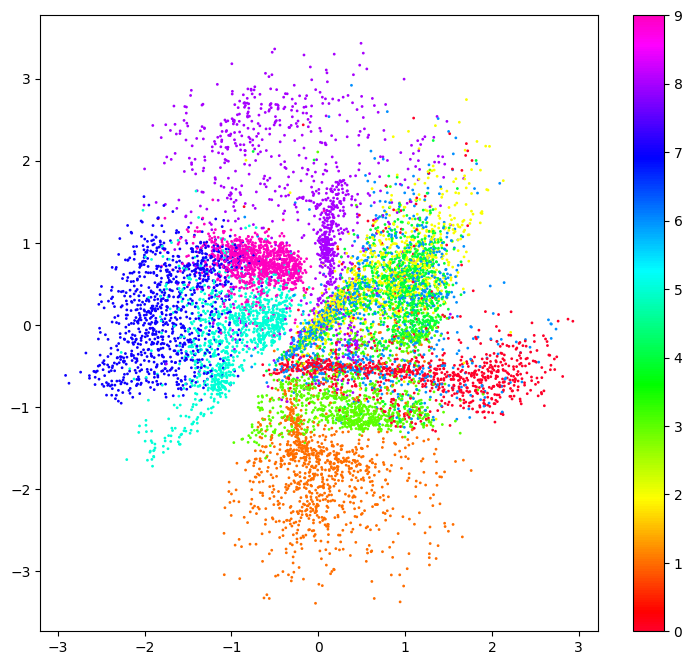

In [60]:
plt.figure(figsize=(9,8))
scatter = plt.scatter(z_mean_total[:, 0], z_mean_total[:, 1], c=y_total, s=1, cmap='gist_rainbow')
plt.colorbar(scatter)
plt.show()

In [48]:
mins, maxs = np.min(z_total, axis=0), np.max(z_total, axis=0)
sample = np.random.uniform(mins, maxs, size=(18,2))
sample_tensor = torch.tensor(sample)
sample_tensor = sample_tensor.to(device).float()
reconstructions = model.decoder(sample_tensor)

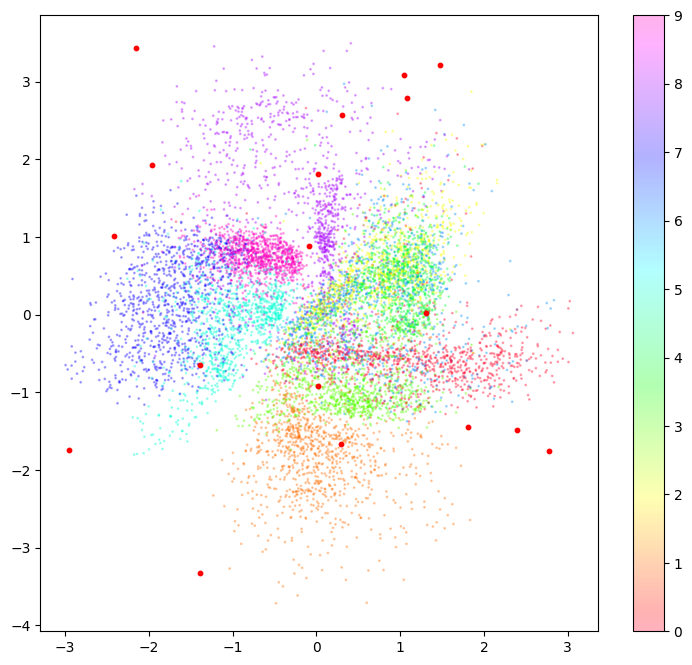

In [49]:
plt.figure(figsize=(9,8))
scatter = plt.scatter(z_total[:, 0], z_total[:, 1], c=y_total, s=1, cmap='gist_rainbow', alpha=0.3)
plt.colorbar(scatter)
plt.scatter(sample[:, 0], sample[:, 1], c="r", s=10)
plt.show()

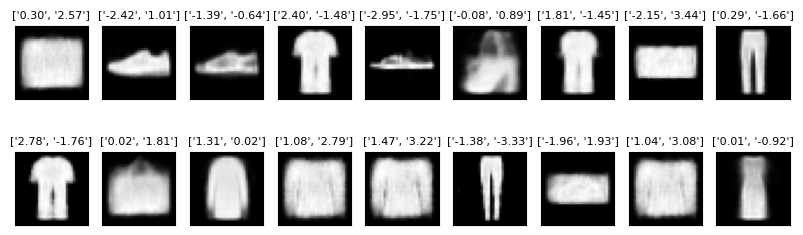

In [52]:
recons = reconstructions.detach().squeeze().cpu().numpy()

fig, axs = plt.subplots(nrows=2, ncols=9, figsize=(10,3))
for i in range(recons.shape[0]):
    plot = axs[i // 9, i % 9]
    plot.set_xticks([])
    plot.set_yticks([])
    plot.imshow(recons[i], cmap='grey')
    
    plot.set_title([f"{v:.2f}" for v in sample[i]], fontsize=8)
    


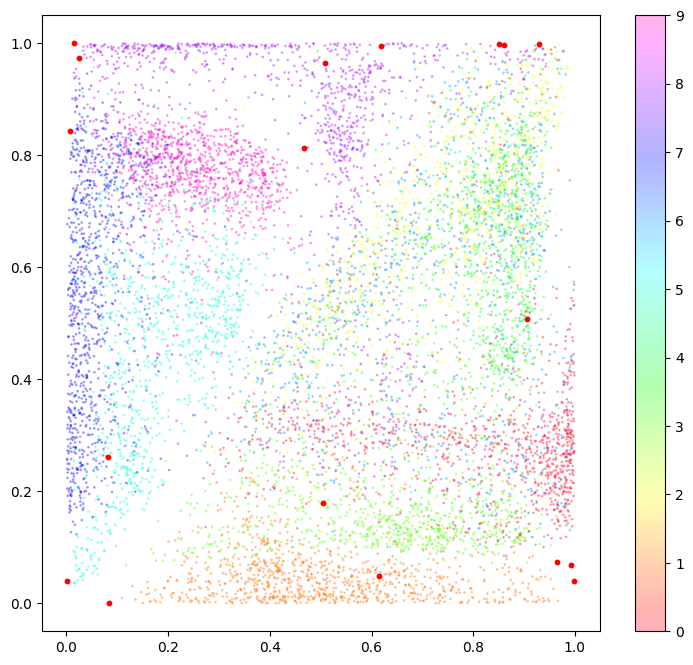

In [53]:
# Convert original embeddings and sampled embeddings to p-values
p = norm.cdf(z_total)
p_sample = norm.cdf(sample)

plt.figure(figsize=(9,8))
scatter = plt.scatter(p[:, 0], p[:, 1], c=y_total, s=1, cmap='gist_rainbow', alpha=0.3)
plt.colorbar(scatter)
plt.scatter(p_sample[:, 0], p_sample[:, 1], c="r", s=10)
plt.show()